##### Import all the required libraries

In [1]:
import numpy as np
import nltk
from nltk.corpus import brown
from nltk.probability import FreqDist
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import KFold
from collections import defaultdict
from mlxtend.plotting import heatmap
import matplotlib.pyplot as plt
import copy
from nltk.tokenize import word_tokenize

nltk.download('brown')
nltk.download('universal_tagset')
nltk.download('punkt')

[nltk_data] Downloading package brown to /home/sarvam/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/sarvam/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package punkt to /home/sarvam/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
tagged_sents = brown.tagged_sents(tagset='universal')

print("Number of sentences in corpus: ", len(tagged_sents))
print("Some of the sentences are shown below")
[print(f"{i}\n\n") for i in tagged_sents[:2]]


Number of sentences in corpus:  57340
Some of the sentences are shown below
[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')]


[('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN')

[None, None]

### Collecting unique tags in corpus

In [3]:
# We will also make a list of all the unique states
states = set()

for sent in tagged_sents:
    for _, tag in sent:
        states.add(tag)
states = list(states)

states.sort()

states

['.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X']

### Method to learn HMM probabilities

In [4]:
def learn_hmm_param(training_set):
    
    # tagged_words is a list that contains all the words present in training set
    tagged_words = [word for sent in training_set for word in sent]
    
    # Declaring two dictionaries that will store transition and emission probabilities
    tran_prob = defaultdict(int)
    emm_prob = defaultdict(int)
    init_prob = defaultdict(int)
    
    # Declaring two dictionaries tran_freq that will store the frequency of a tag given prev tag (bigram assumption)
    # And emm_freq that will store the frequency of the word given a tag
    tran_freq = defaultdict(int)
    emm_freq = defaultdict(int)
    
    
    # Let's assume our every sentence starts with a sentence starter '^'
    for sent in training_set:
        
        prev_tag = '^'   # keeps track of the prev tag which is used to calc the frequency
        t_sent = copy.deepcopy(sent)
        t_sent.append(("$", "$"))
        
        for word, tag in t_sent:
            
            # First we will calculate tran_freq[(tag, prev_tag)] i.e. frequency of current tag given previous tag
            tran_freq[(tag, prev_tag)] += 1
            
            # Now we will calculate the emm_freq[(word, tag)] i.e. frequency of a current word given current tag
            # We will convert the word in lowercase to consider 'People' and 'people' same
            if (tag != "$"):
                emm_freq[(word.lower(), tag)] += 1
            
            # Update the prev tag to current tag
            prev_tag = tag
            
    # Now we will calculate the tag_counts i.e. number of times each tag appears in our training set
    # This will be helpful in calculating the probabilities
    tag_count = defaultdict(int)
    for _, tag in tagged_words:
        tag_count[tag] += 1

    tag_count["."] -= tran_freq[("$", ".")]
    
        
    # Now we have the frequency dictionaries using this we will calculate the transition and emission probabilites
    # P(tag | prev_tag) = count(tag, prev_tag) / count(prev_tag)
    for tag, prev_tag in tran_freq:
        if(prev_tag == '^'):
            init_prob[(tag, prev_tag)] = tran_freq[(tag, prev_tag)]/len(training_set)
        else:
            tran_prob[(tag, prev_tag)] = tran_freq[(tag, prev_tag)]/tag_count[prev_tag]
    
    #P(word | tag) = count(word, tag) / count(tag)
    for word, tag in emm_freq:
        emm_prob[(word.lower(), tag)] = emm_freq[(word, tag)] / tag_count[tag]

    return init_prob, tran_prob, emm_prob

    

### Viterbi algorithm to predcit pos tag sequence

In [5]:
def viterbi(word_seq, init_prob, tran_prob, emm_prob):

    # prob to use in case key is not found
    min_prob = 1e-8
    
    # Let 'n' be the number of states and 'w' be the number of words
    n = len(states)
    w = len(word_seq)
    
    # Since viterbi decoding is a dynamic programming approach we will make a matrix vit_mat to keep track of
    # the best probabilities of each tag for a given word
    vit_mat = np.zeros((n, w))
    
    # We will also make a matrix that will keep track of the best prev tag for the current tag
    # This we will use to backtrack to find the best combination of tags
    path_mat = np.zeros((n, w), dtype=int)
    
    # First we will initialize the vit_mat for the first word
    for idx, state in enumerate(states):
        vit_mat[idx][0] = init_prob.get((state, '^'), min_prob)*emm_prob.get((word_seq[0], state), min_prob)
        
    
    # Now we will go through every tag for each word and store the best prob for that current state
    for word_idx in range(1, w):
        for idx, tag in enumerate(states):
            
            # We will make two variable
            # max_prob will keep track of the maximum probability of transition from prev tag to current tag
            # best state will store the index of the prev state from where we got the max probability
            max_prob = -1
            best_state = -1
            
            # We will go through all the prev states for current state
            for prev_state_idx in range(n):
                
                # We will calculate the probability of current state from prev state
                prob = vit_mat[prev_state_idx][word_idx-1] * tran_prob.get((states[idx], states[prev_state_idx]), min_prob) * emm_prob.get((word_seq[word_idx], states[idx]), min_prob)
                
                # Check if prob is greater than max prob then update the parameters
                if(prob > max_prob):
                    max_prob = prob
                    best_state = prev_state_idx   # Best previous state from where we can come to current state
            
            # Now store the max prob for the current state in our vit_mat
            # Also store the best prev state for the current state
            vit_mat[idx][word_idx] = max_prob
            path_mat[idx][word_idx] = best_state
        
        
    # Now that we got our vit_mat and path_mat we will backtrack and find the best tag sequence
    # First let's initilize our final path list
    final_path = [-1]*w
    
    highest_prob = -1   # To store highest probability of our tag sequence
    for idx in range(n):
        if(vit_mat[idx][w-1] > highest_prob):
            highest_prob = vit_mat[idx][w-1]
            final_path[w-1] = idx
    
    # Backtrack from second last word to the first word and store the best state for every word
    for idx in range(w-2, -1, -1):
        final_path[idx] = path_mat[final_path[idx+1]][idx+1]
        
    
    # Now return the list of best possible tags
    return [states[i] for i in final_path], highest_prob
        
    
        

### 5-fold cross validation 

Confusion matrix for fold 1: 



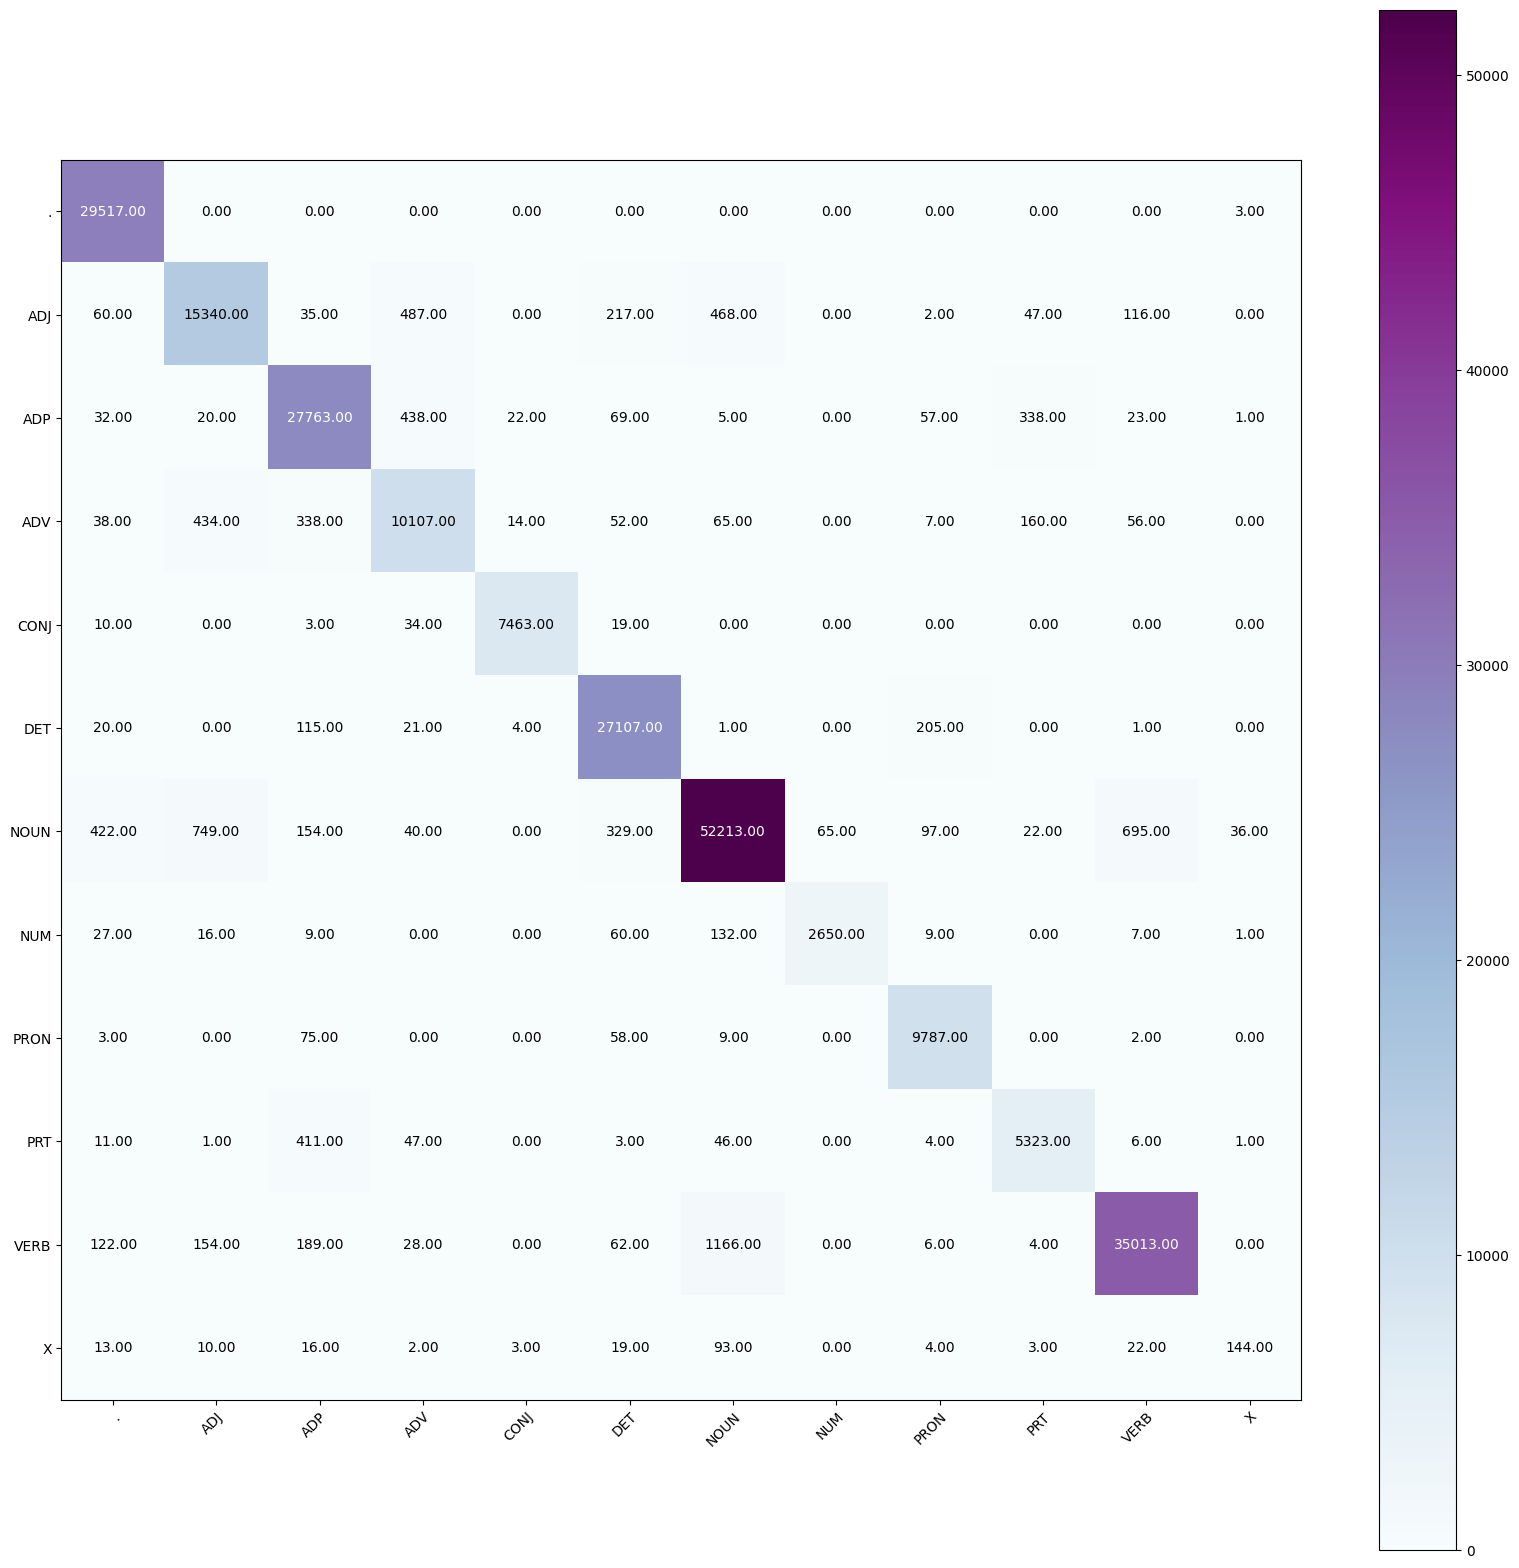


----------------------------------------------------------------------

Precision per tags for the fold 1 are:
. :  0.9998983739837398
ADJ :  0.9146196041020749
ADP :  0.9650653503893215
ADV :  0.8967261112589833
CONJ :  0.9912338956036658
DET :  0.9866419159933028
NOUN :  0.9524096165772865
NUM :  0.9103400893163861
PRON :  0.9852023354137306
PRT :  0.9094481462497864
VERB :  0.9528902677988244
X :  0.4376899696048632

Recall per tag for the fold 1 are: 
. :  0.9749628406275805
ADJ :  0.9172446783066253
ADP :  0.9537927717465988
ADV :  0.9020885398072117
CONJ :  0.9942712496669331
DET :  0.9682800500089301
NOUN :  0.9633750322890143
NUM :  0.9760589318600368
PRON :  0.9615838082137944
PRT :  0.9026623706969645
VERB :  0.974179905956985
X :  0.7741935483870968

F1 Score per tag for the fold 1 are: 
. :  0.9872731833765365
ADJ :  0.9159302603295917
ADP :  0.9593959499619877
ADV :  0.8993993325917686
CONJ :  0.9927502494180246
DET :  0.9773747498602823
NOUN :  0.9578609429462485
NUM :  

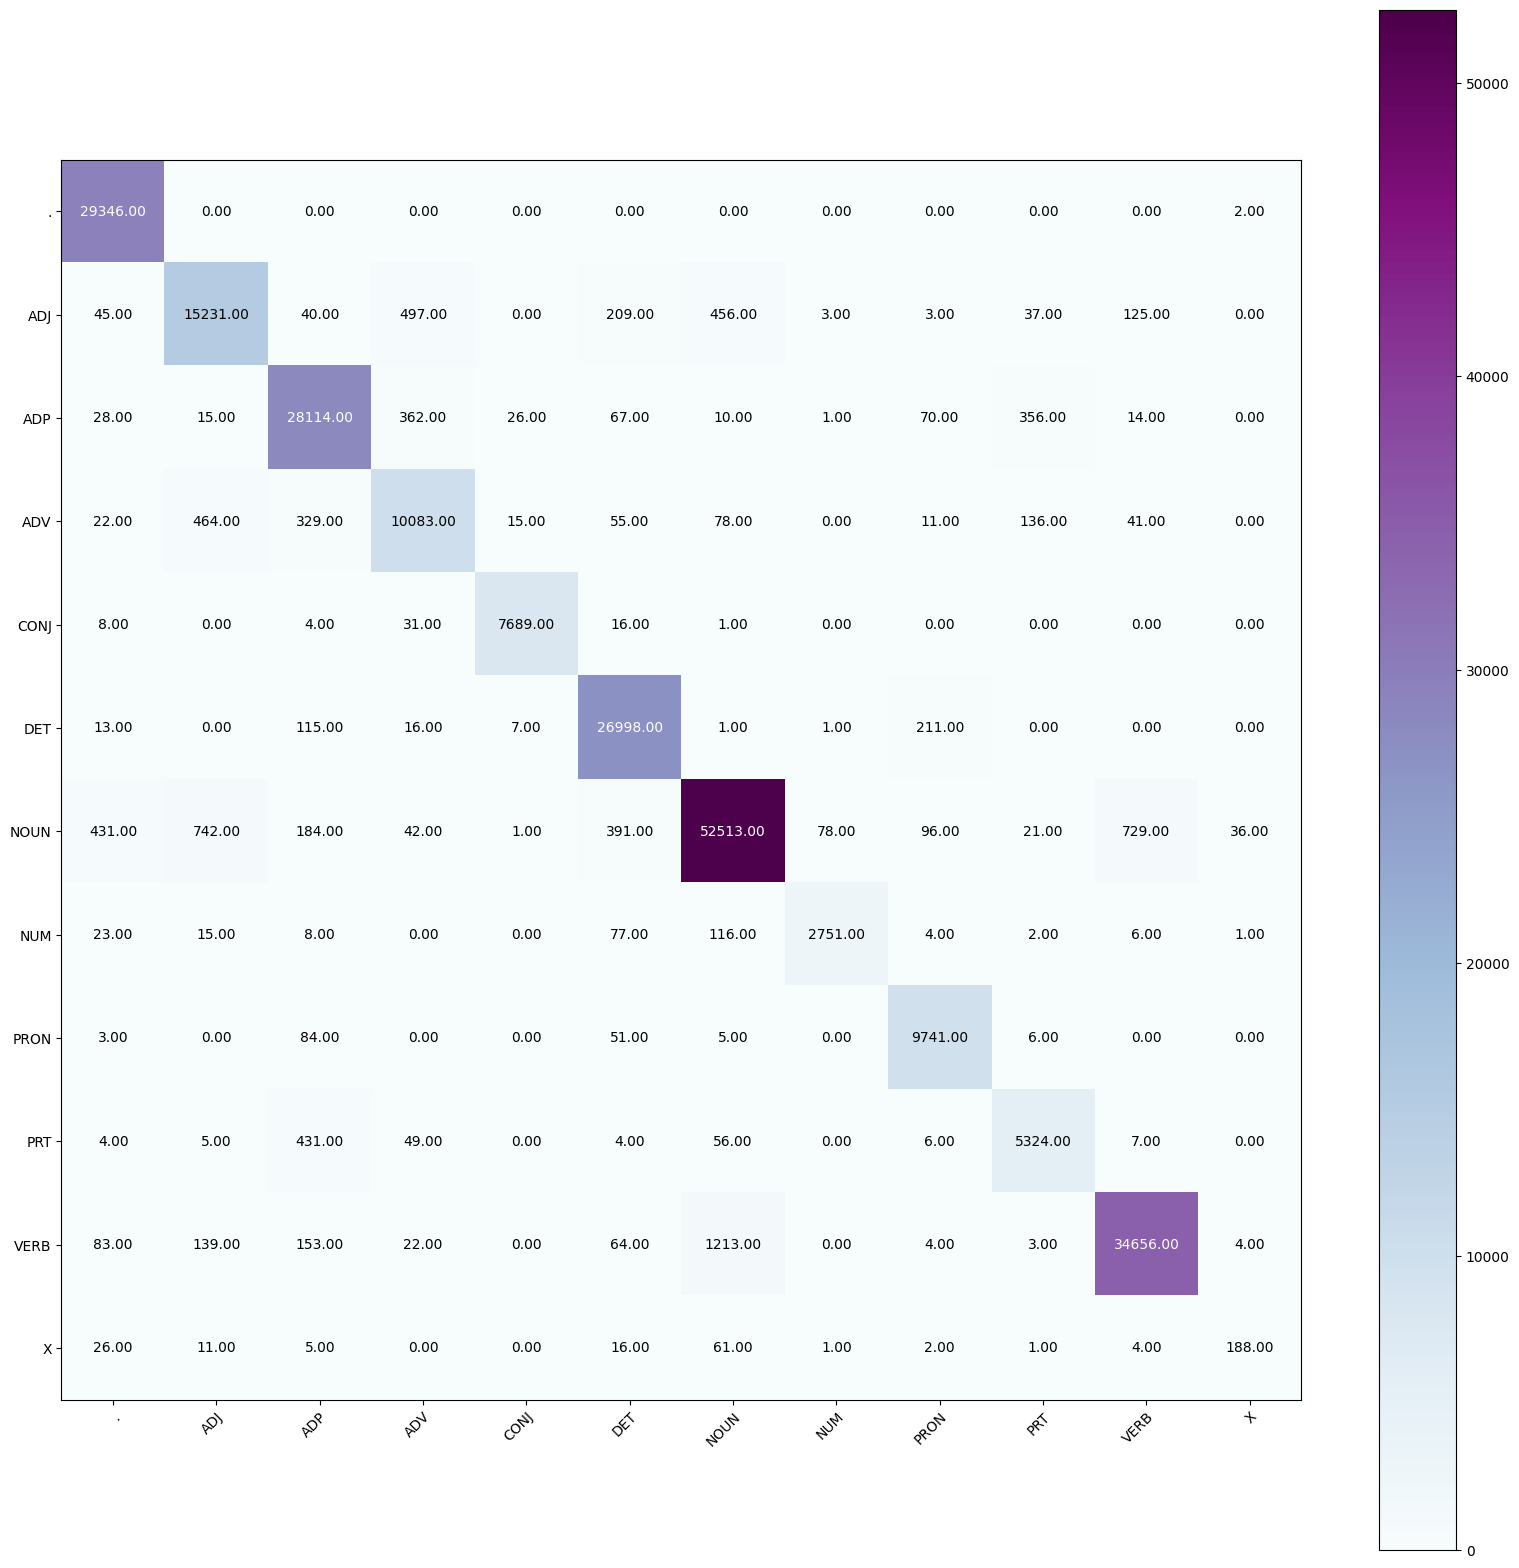


----------------------------------------------------------------------

Precision per tags for the fold 2 are:
. :  0.9999318522556904
ADJ :  0.9149945932956867
ADP :  0.9673467983346523
ADV :  0.8975431725120171
CONJ :  0.9922570654277971
DET :  0.9866968788831226
NOUN :  0.9502207585408222
NUM :  0.916083916083916
PRON :  0.9849342770475228
PRT :  0.9045191980971797
VERB :  0.9536336369389945
X :  0.5968253968253968

Recall per tag for the fold 2 are: 
. :  0.9771576984549813
ADJ :  0.9163157261460715
ADP :  0.9540842298164048
ADV :  0.9082147360835885
CONJ :  0.9936676143706384
DET :  0.9660083011306713
NOUN :  0.9633645202715098
NUM :  0.9703703703703703
PRON :  0.9598935750886874
PRT :  0.9045191980971797
VERB :  0.9739756056433028
X :  0.8138528138528138

F1 Score per tag for the fold 2 are: 
. :  0.9884136072751769
ADJ :  0.9156546831790309
ADP :  0.9606697420126431
ADV :  0.9028474212034383
CONJ :  0.9929618389617099
DET :  0.9762429940336287
NOUN :  0.9567474994078743
NUM :  

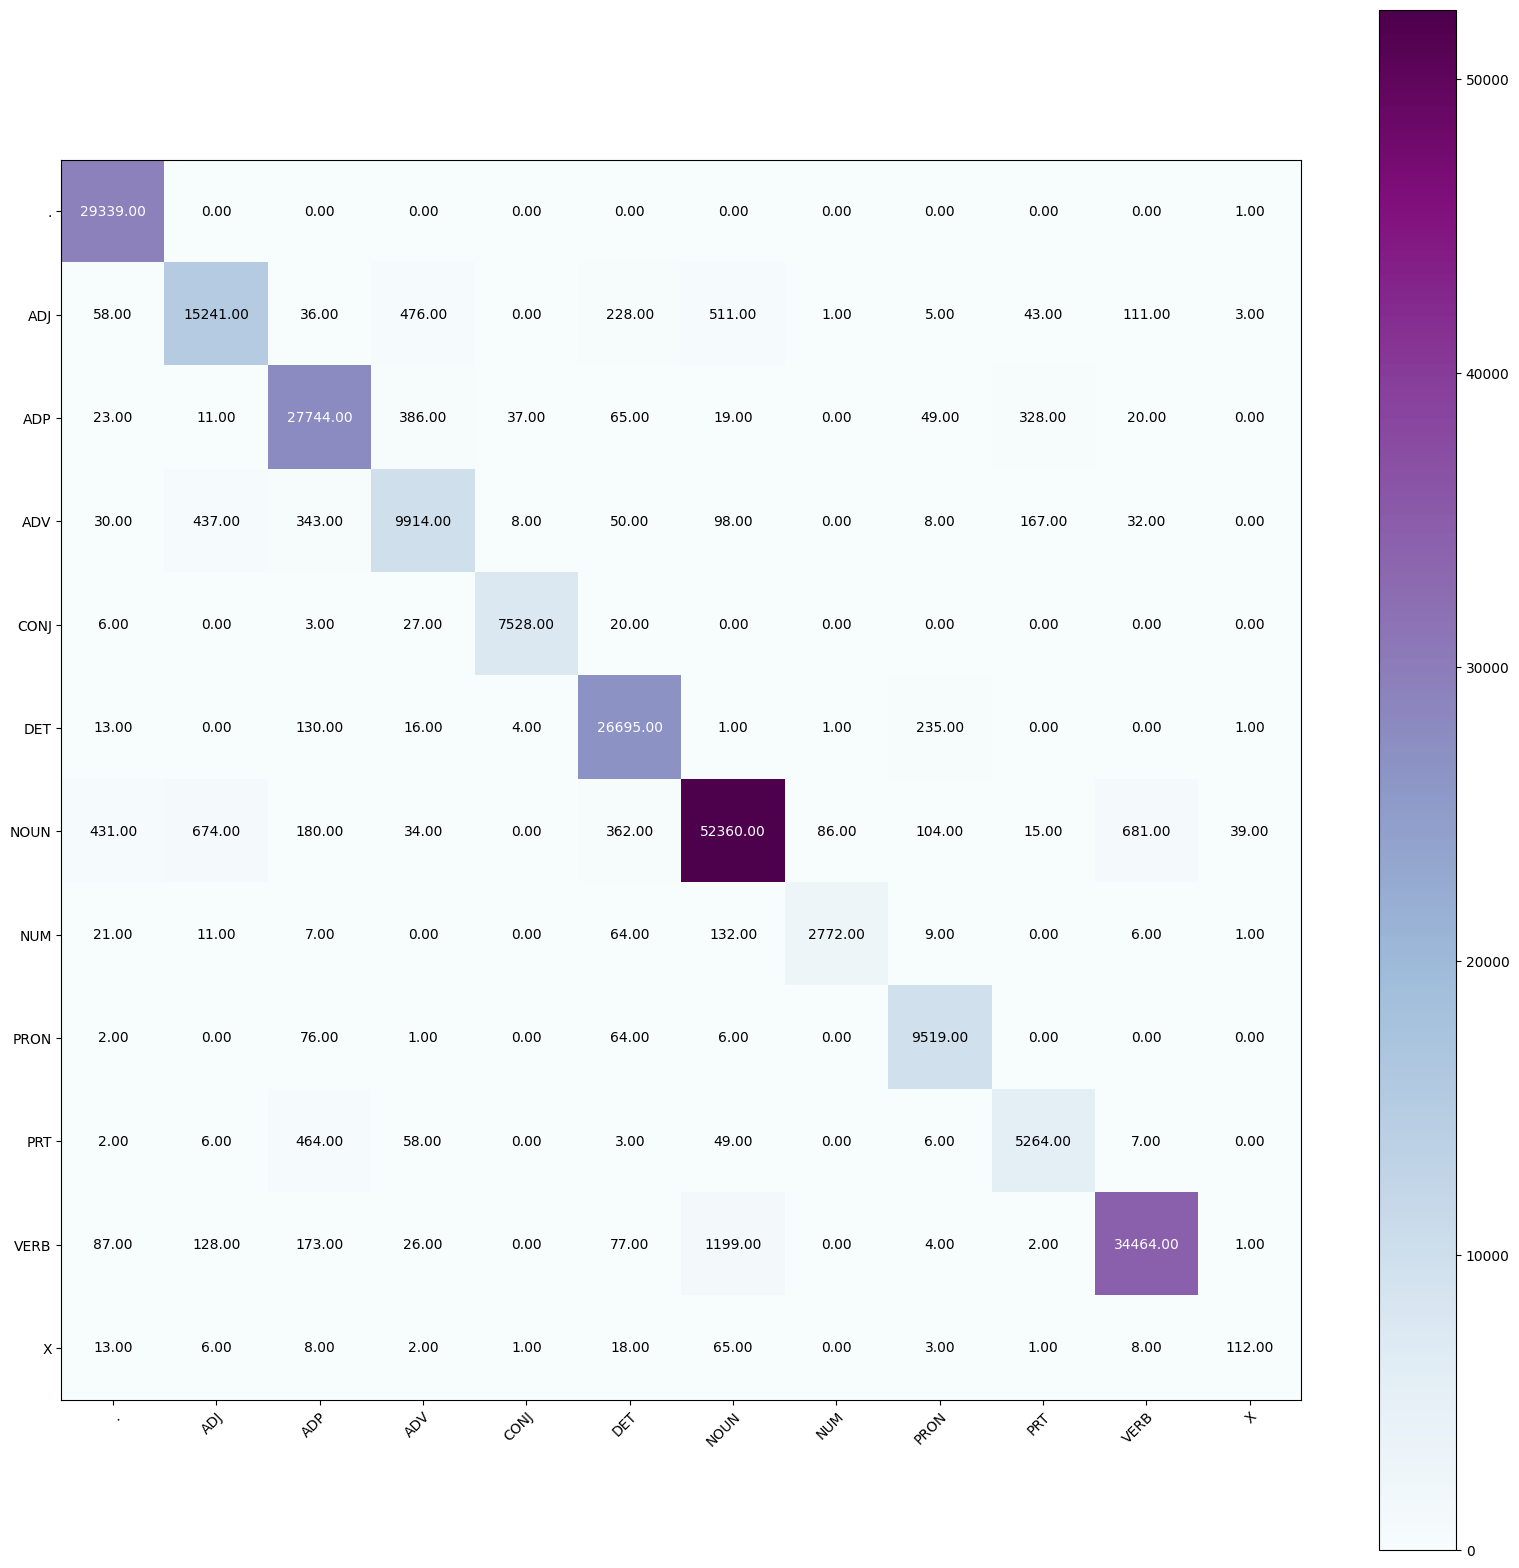


----------------------------------------------------------------------

Precision per tags for the fold 3 are:
. :  0.9999659168370825
ADJ :  0.9119248489200024
ADP :  0.9672965623038839
ADV :  0.8942004149003338
CONJ :  0.9926160337552743
DET :  0.9852007676409802
NOUN :  0.952588873121566
NUM :  0.9169698974528614
PRON :  0.9845883326437733
PRT :  0.8984468339307049
VERB :  0.9530709880810818
X :  0.47257383966244726

Recall per tag for the fold 3 are: 
. :  0.9771523730224813
ADJ :  0.9229138912437932
ADP :  0.9513098340419696
ADV :  0.9062157221206582
CONJ :  0.9934019530219055
DET :  0.9656008102437966
NOUN :  0.9617927994121969
NUM :  0.9692307692307692
PRON :  0.9574532287266143
PRT :  0.90446735395189
VERB :  0.9755158651532735
X :  0.7088607594936709

F1 Score per tag for the fold 3 are: 
. :  0.988427524635728
ADJ :  0.9173864628163843
ADP :  0.959236593714345
ADV :  0.9001679756662277
CONJ :  0.9930088378841841
DET :  0.9753023272806987
NOUN :  0.9571687110396138
NUM :  0.9

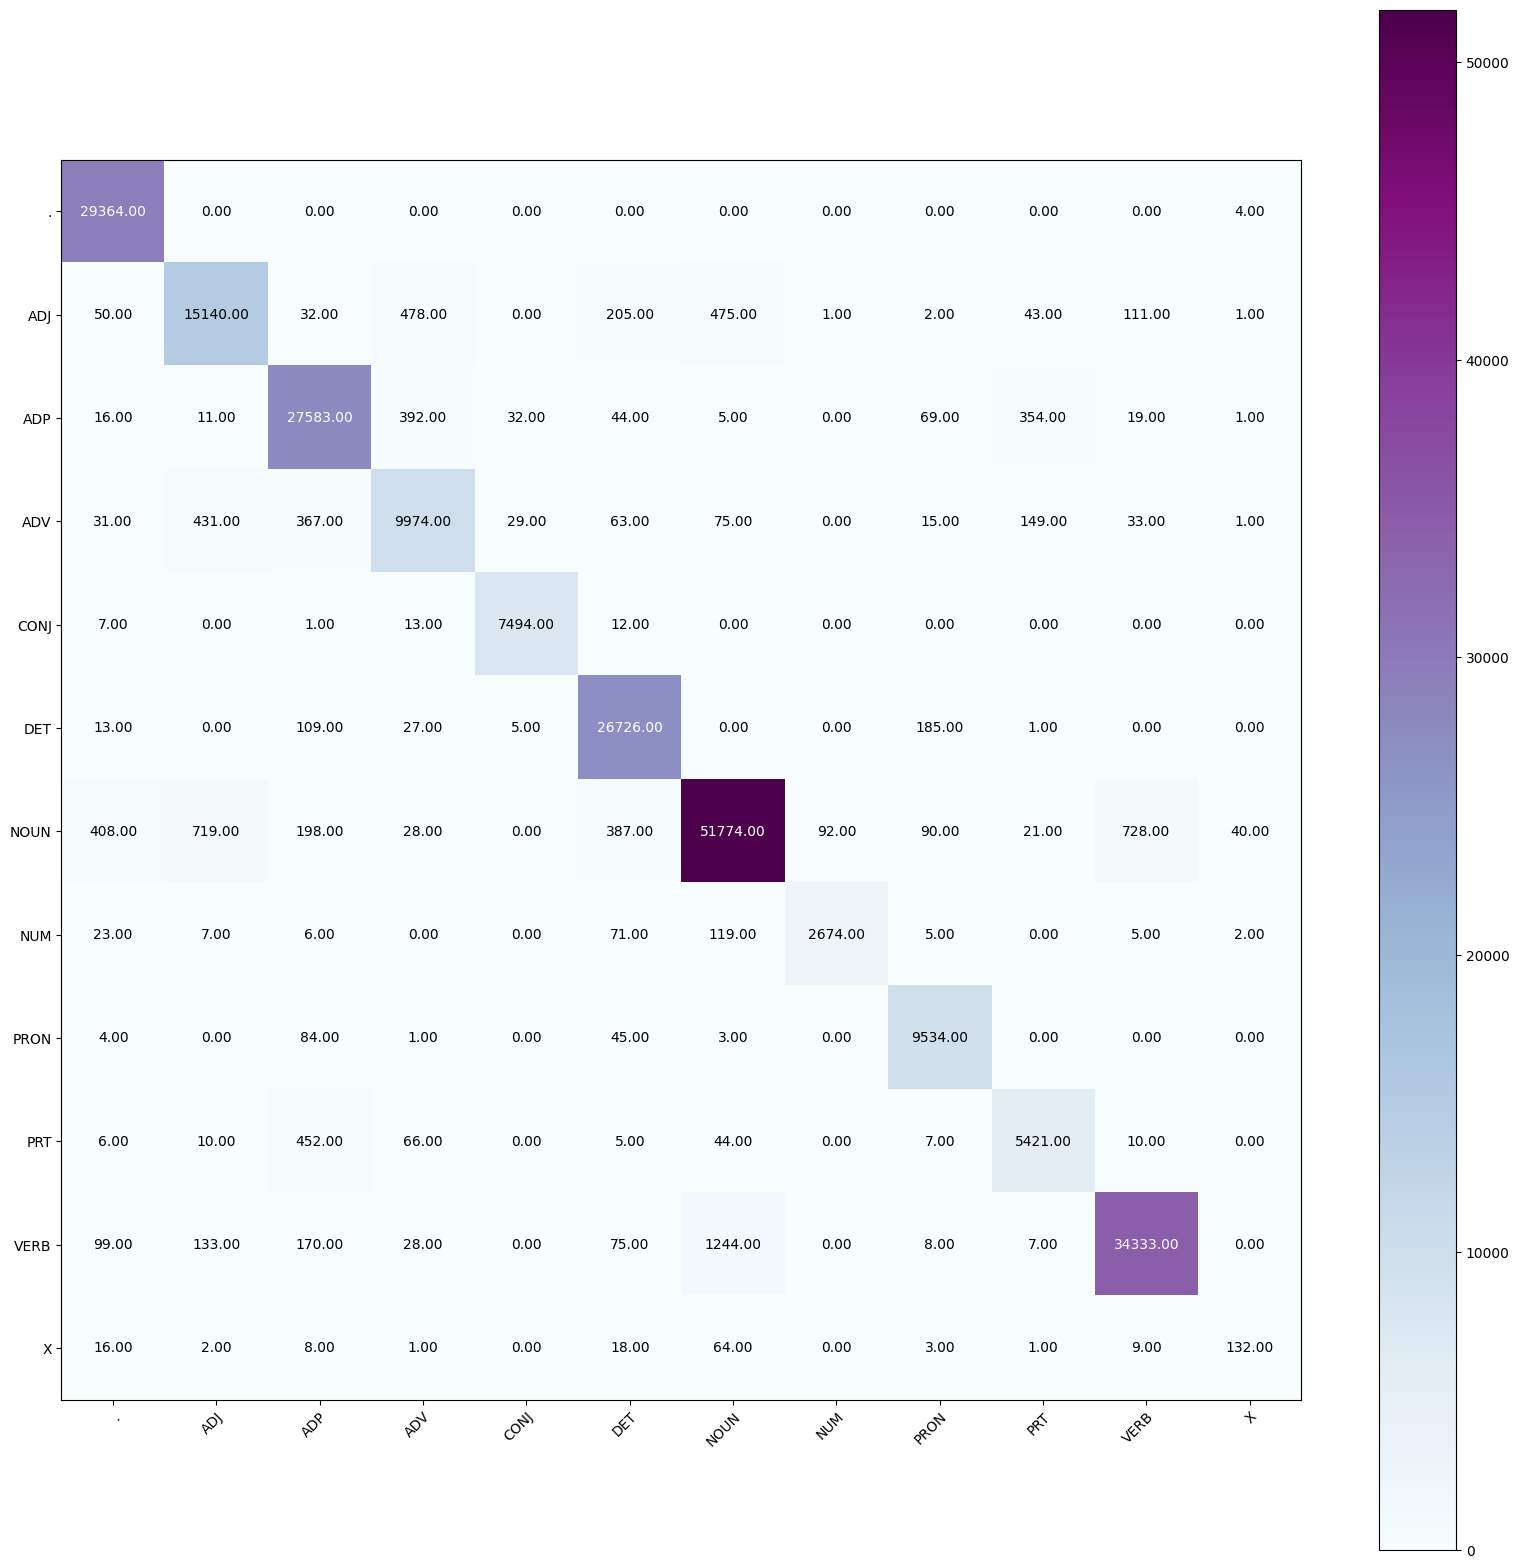


----------------------------------------------------------------------

Precision per tags for the fold 4 are:
. :  0.9998637973304276
ADJ :  0.9154674083927924
ADP :  0.9669424384771788
ADV :  0.8930873925501432
CONJ :  0.99561578318055
DET :  0.987438114239267
NOUN :  0.9502431861980362
NUM :  0.9182692307692307
PRON :  0.9858339365112191
PRT :  0.9003487792725461
VERB :  0.9511316729922155
X :  0.5196850393700787

Recall per tag for the fold 4 are: 
. :  0.9775943003628857
ADJ :  0.9201969245730262
ADP :  0.950810065494657
ADV :  0.9060683139534884
CONJ :  0.9912698412698413
DET :  0.9665473219775054
NOUN :  0.9622883482333698
NUM :  0.966389591615468
PRON :  0.9612825166364186
PRT :  0.903951975987994
VERB :  0.9740410803449842
X :  0.7292817679558011

F1 Score per tag for the fold 4 are: 
. :  0.9886036528911708
ADJ :  0.917826073777697
ADP :  0.9588083982202448
ADV :  0.8995310245310245
CONJ :  0.9934380592563133
DET :  0.976881042454813
NOUN :  0.9562278368794327
NUM :  0.94171

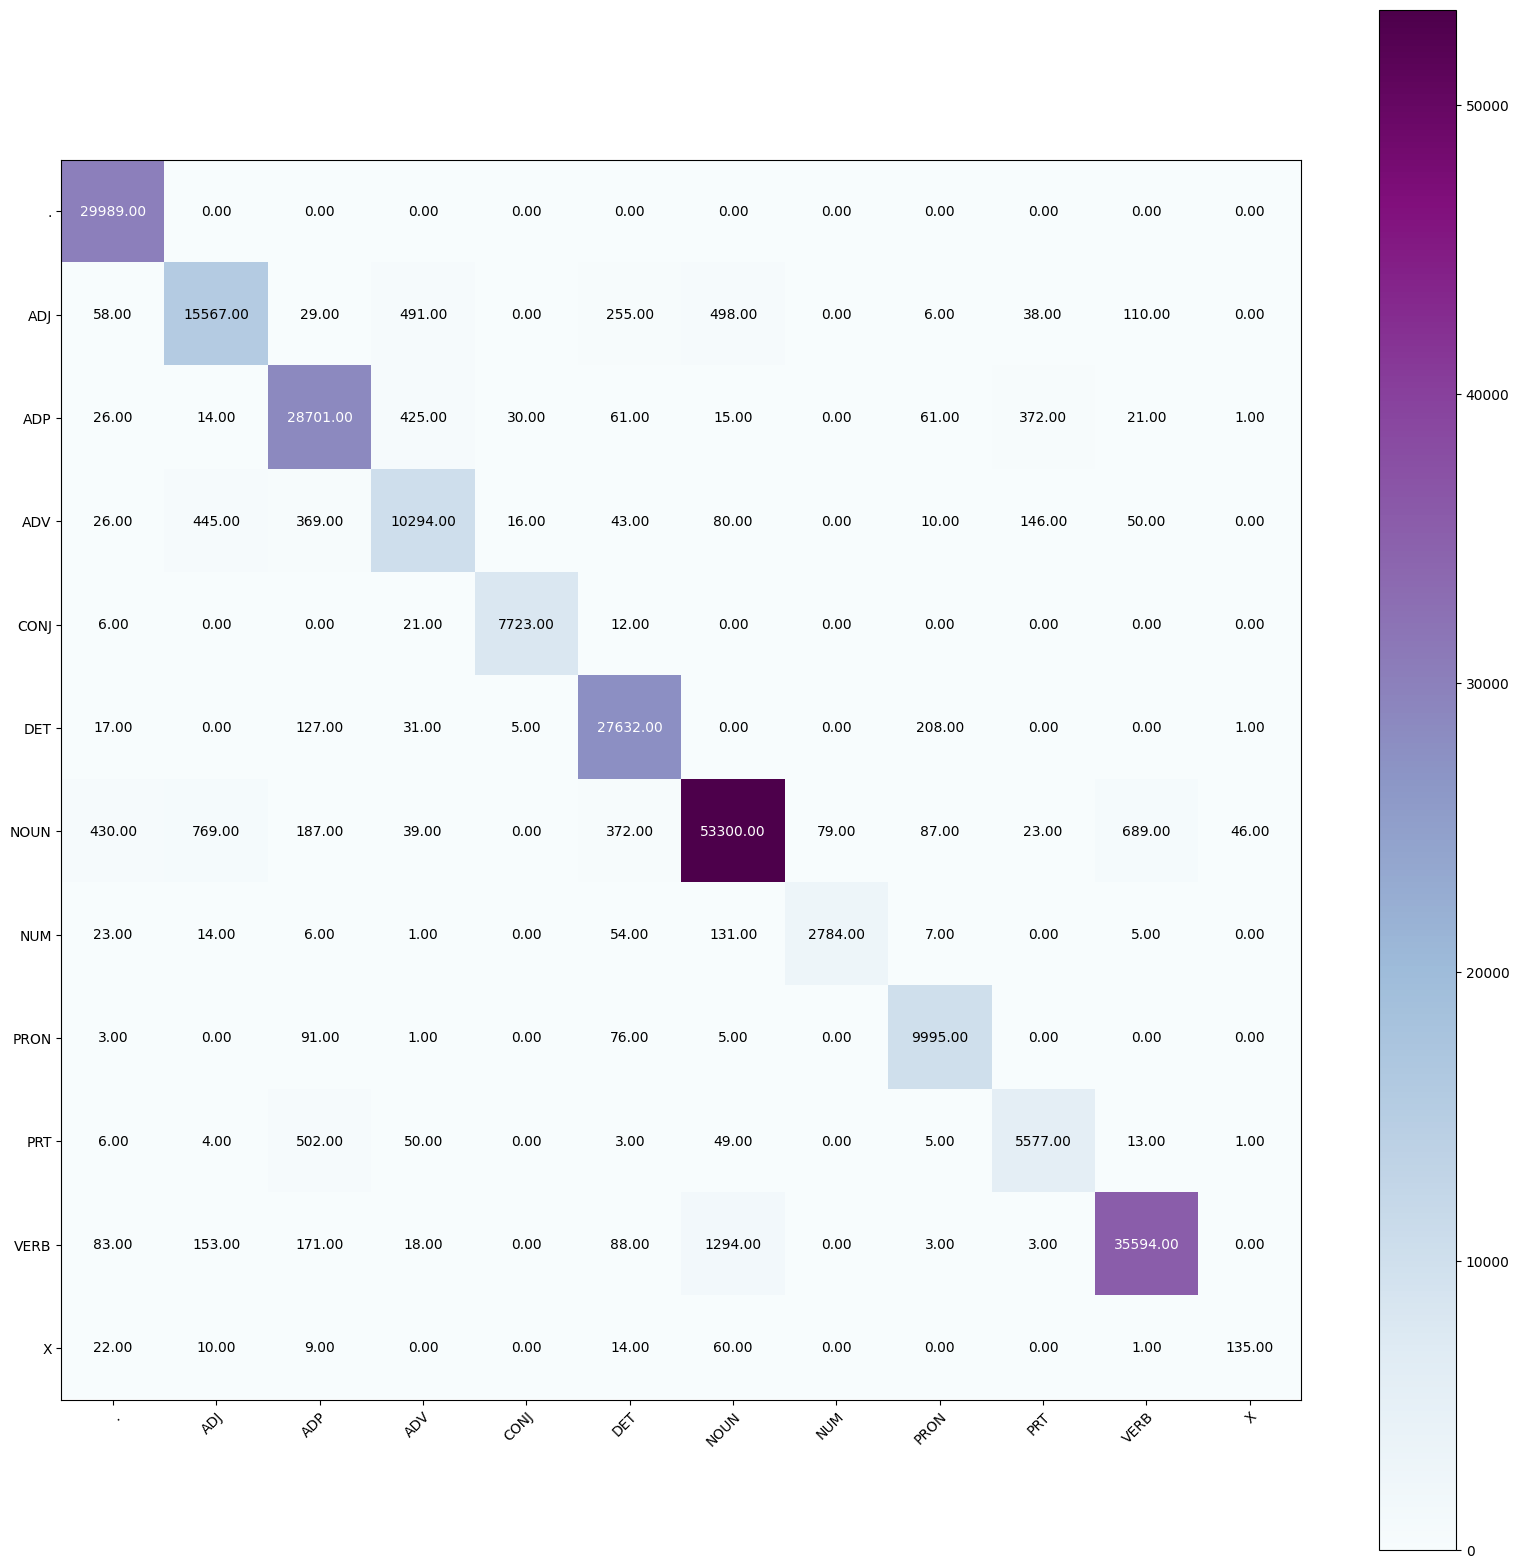


----------------------------------------------------------------------

Precision per tags for the fold 5 are:
. :  1.0
ADJ :  0.9129134412385644
ADP :  0.9654859218891917
ADV :  0.8967680111507971
CONJ :  0.994975521772739
DET :  0.9861175546911245
NOUN :  0.9514289284375502
NUM :  0.9203305785123967
PRON :  0.9826959001081507
PRT :  0.8980676328502415
VERB :  0.9515331355093967
X :  0.5378486055776892

Recall per tag for the fold 5 are: 
. :  0.9771905242920916
ADJ :  0.9170004712535345
ADP :  0.9506160572337043
ADV :  0.9052853750769502
CONJ :  0.9934396706971957
DET :  0.9658161481999301
NOUN :  0.9615384615384616
NUM :  0.9724065665385959
PRON :  0.9627239452899249
PRT :  0.9055041402825134
VERB :  0.9756324863635117
X :  0.7336956521739131

F1 Score per tag for the fold 5 are: 
. :  0.9884636935957019
ADJ :  0.9149523921476432
ADP :  0.9579932909427729
ADV :  0.9010065645514224
CONJ :  0.9942070030895984
DET :  0.975861277392241
NOUN :  0.9564569818667958
NUM :  0.94565217391304

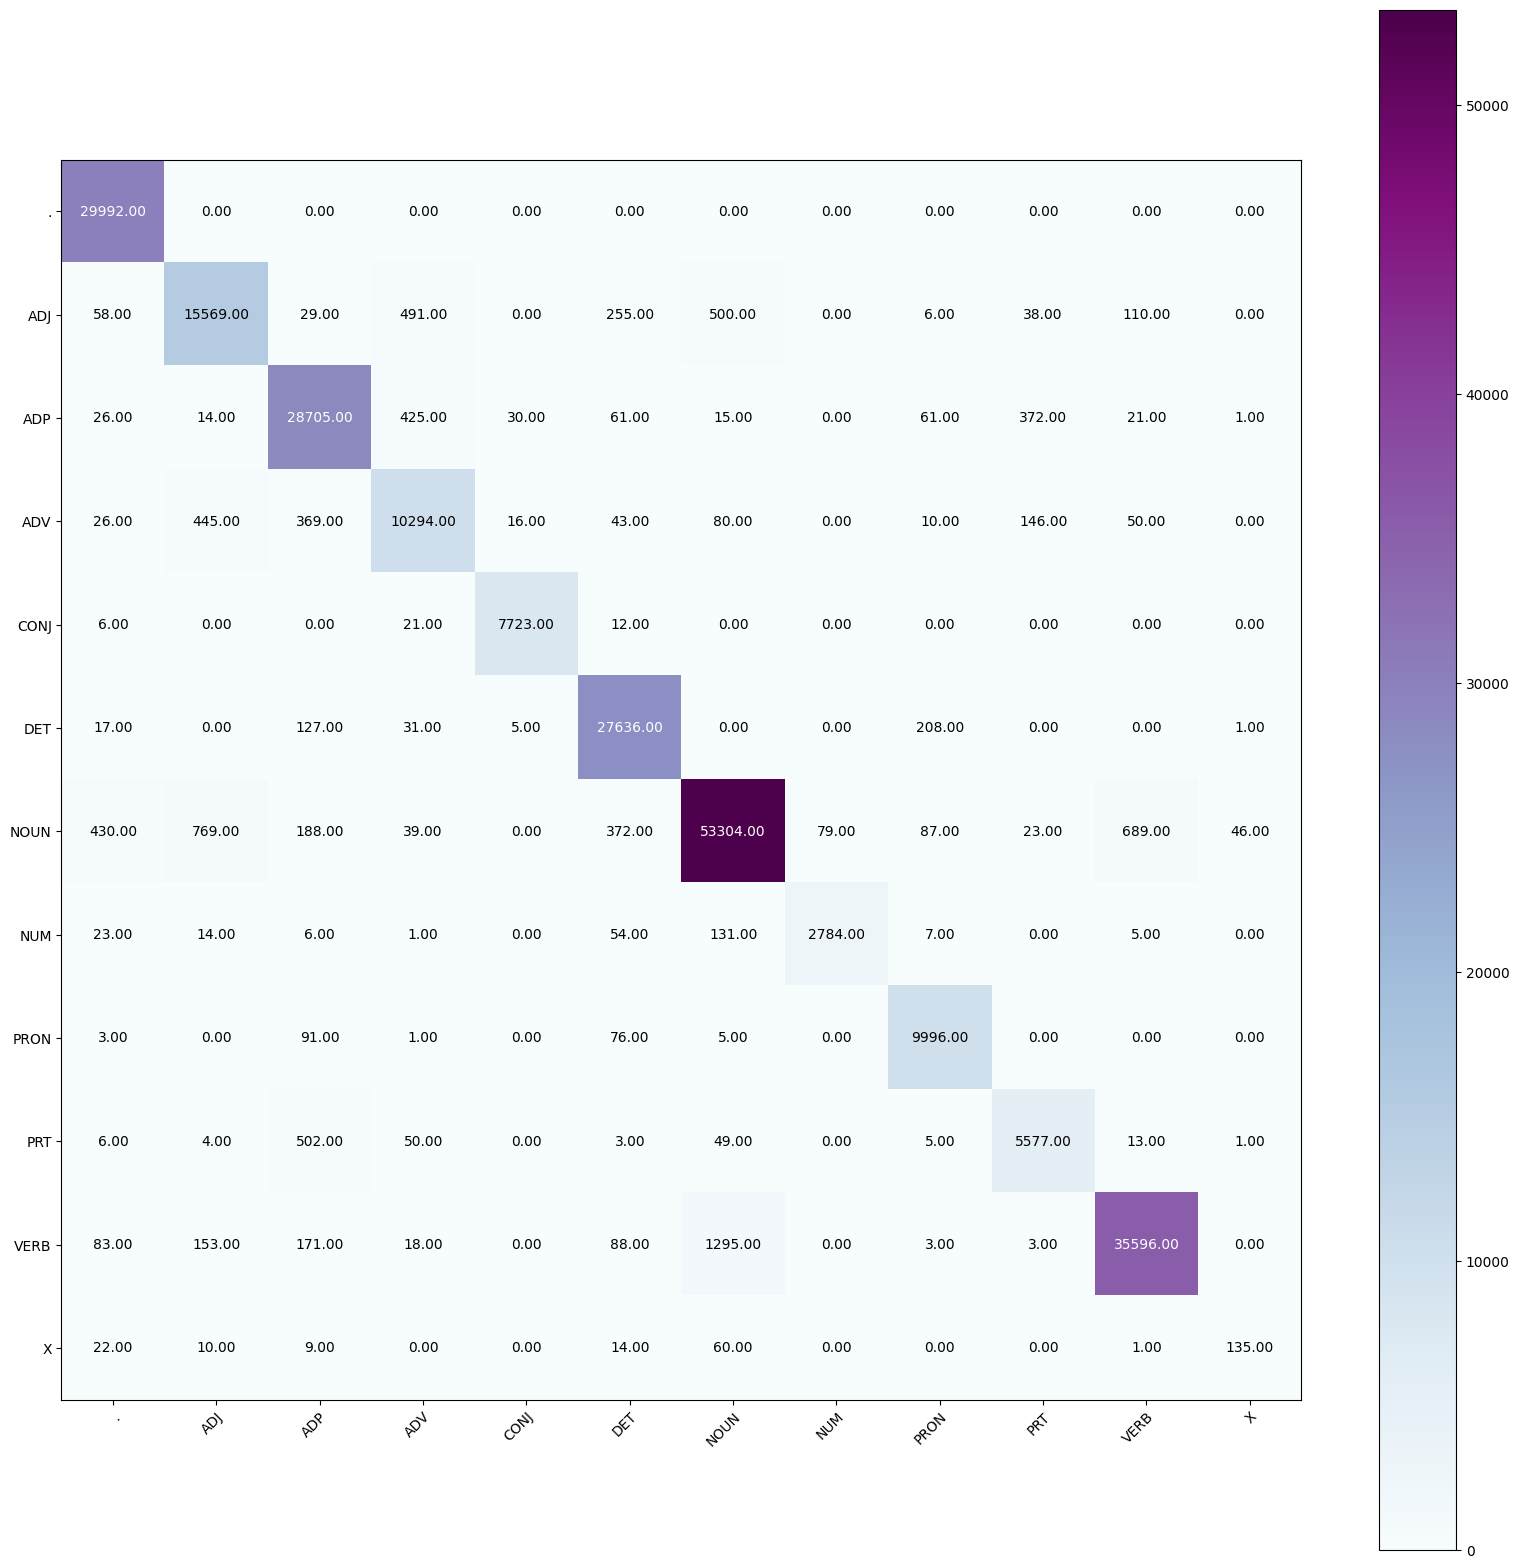

In [6]:
# Decalaring some variables like conf_matrix that will store the confusion matrix at each fold
# pos_accuracy will store the accuracy of veterbi at each fold

# We will declare a list that will store the accuracy at each fold
accuracy = []
precision_overall = []
recall_overall = []
actual_tags = []
predicted_tags = []

folds = KFold(n_splits=5, shuffle=True, random_state=42) # Defining 5 fold splits
fold_idx = 1 

for training_idx, testing_idx in folds.split(tagged_sents):
    
    training_set = [tagged_sents[i] for i in training_idx]   # contains the tagged sentences used for calc prob
    test_set = [tagged_sents[i] for i in testing_idx]     # contains the tagged sentesced used for testing
    
    # Learn initial, tranistion, emmision probabilities from training data
    init_prob, tran_prob, emm_prob = learn_hmm_param(training_set)

    
    # Now we will declare two variables
    # fold_pred_tags is a list that will store the predicted tags for all the words in test set
    # fold_act_tags is a list that will store the actual tags for all the words in test set
    fold_pred_tags = []
    fold_act_tags = []

    
    
    # Now we will go through every sentence in 
    for sent in test_set:
        
        # First we will store the actual tags of current sentence in a list
        actual_tags = [tag for _, tag in sent]
        
        # Now we will store the word sequence that we have to pass in viterbi function
        # we will store the words in lowercase
        word_seq = [word.lower() for word, _ in sent]
        
        # Now we will get the list of predicted tags using the Viterbi function
        pred_tags, pred_prob = viterbi(word_seq, init_prob, tran_prob, emm_prob)
        
        # Now we have predicted tag sequence
        # Add the predicted tag and actual tag list in our fold list
        fold_pred_tags.extend(pred_tags)
        fold_act_tags.extend(actual_tags)

    actual_tags.extend(fold_act_tags)
    pred_tags.extend(fold_pred_tags)
    
    # Now we will find the confusion matrix for the current fold and print it
    fold_conf_mat = confusion_matrix(fold_act_tags, fold_pred_tags)
    print(f"Confusion matrix for fold {fold_idx}: \n")
    
    heatmap(fold_conf_mat, column_names=states, row_names=states, figsize=(20,20), cmap="BuPu")
    plt.show()
    
    print("\n----------------------------------------------------------------------\n")
    # Printing the precision, recall and F1 score of every tag in current fold
    precision = []
    recall =[]
    
    # Printing the precision of every tag in current fold
    print(f"Precision per tags for the fold {fold_idx} are:")
    for idx, state in enumerate(states):
        temp_prec = fold_conf_mat[idx][idx] / np.sum(fold_conf_mat[idx])
        precision.append(temp_prec)
        print(state, ": ", temp_prec)

    precision_overall.append(precision)
        
    # Printing the recall of every tag in current fold
    print(f"\nRecall per tag for the fold {fold_idx} are: ")
    temp = np.sum(fold_conf_mat, axis = 0)
    temp = temp.tolist()
    for idx, state in enumerate(states):
        temp_rec = fold_conf_mat[idx][idx] / temp[idx]
        recall.append(temp_rec)
        print(state,": ", temp_rec)

    recall_overall.append(recall)
    
    # Printing the F1 score of every tag in the current fold
    print(f"\nF1 Score per tag for the fold {fold_idx} are: ")
    for idx, state in enumerate(states):
        temp_f1 = (2*precision[idx]*recall[idx])/(precision[idx]+recall[idx])
        print(state, ": ", temp_f1)
    
    print("\n----------------------------------------------------------------------\n")
    # We will also calculate the accuracy of current fold
    fold_acc = accuracy_score(fold_act_tags, fold_pred_tags)
    print(f"Accuracy for the fold {fold_idx}: ", fold_acc)
    accuracy.append(fold_acc)

    print("\n")
    print("="*100)
    print("\n\n")
    fold_idx += 1
    
# Printing the final mean accuracy
print("Overall metrics:\n\n")
print("Accuracy: ", np.mean(accuracy))

precision_final = np.mean(precision_overall, axis=0)
recall_final = np.mean(recall_overall, axis=0)

print("\nPrecision")
for idx, i in enumerate(states):
    print(f"{i} : {precision_final[idx]}")

print("\nRecall")
for idx, i in enumerate(states):
    print(f"{i} : {recall_final[idx]}")
    
print("\nF1-score")
for idx, i in enumerate(states):
    print(i + ":" + str((2*precision_final[idx]*recall_final[idx])/(precision_final[idx]+recall_final[idx])))

print("\nF0.5-score")
for idx, i in enumerate(states):
    print(i + ":" + str((1.25*precision_final[idx]*recall_final[idx])/(0.25*precision_final[idx]+recall_final[idx])))

print("\nF2-score")
for idx, i in enumerate(states):
    print(i + ":" + str((5*precision_final[idx]*recall_final[idx])/(4*precision_final[idx]+recall_final[idx])))

conf_mat = confusion_matrix(actual_tags, pred_tags)
print("\n\nConfusion matrix for overall data: \n")
heatmap(conf_mat, column_names=states, row_names=states, figsize=(20,20), cmap="BuPu")
plt.show()

    
        
        

### Demo

In [7]:
init_prob, tran_prob, emm_prob = learn_hmm_param(tagged_sents)

def demo(test_sent):
    pred_tags, pred_prob = viterbi([i.lower() for i in word_tokenize(test_sent)], init_prob, tran_prob, emm_prob)

    annotated_sent = " ".join([word_tokenize(test_sent)[i] + "<" + pred_tags[i] + ">" for i in range(len(pred_tags))])
    print(f"Predicted POS tags: {annotated_sent}")
    print(f"Prediction probability: {pred_prob}")


In [8]:
test_sent = "I saw a boy with a telescope"

demo(test_sent)

Predicted POS tags: I<PRON> saw<VERB> a<DET> boy<NOUN> with<ADP> a<DET> telescope<NOUN>
Prediction probability: 2.1553615139298103e-18


#### tran prob

In [9]:
for idx, i in enumerate(states):
    s = 0
    print(i)
    for idx2, j in enumerate(states):
        s += tran_prob.get((j, i), 1e-8)
        
        print("{:.2f} {}".format(tran_prob.get((j, i), 1e-8), j), end="\t")
    print("\n")
    print(s)
    print("\n")

.
0.17 .	0.05 ADJ	0.11 ADP	0.07 ADV	0.11 CONJ	0.11 DET	0.13 NOUN	0.02 NUM	0.07 PRON	0.03 PRT	0.12 VERB	0.00 X	

0.9999999999999999


ADJ
0.10 .	0.06 ADJ	0.09 ADP	0.01 ADV	0.04 CONJ	0.01 DET	0.65 NOUN	0.01 NUM	0.00 PRON	0.02 PRT	0.02 VERB	0.00 X	

0.9996297225307867


ADP
0.01 .	0.08 ADJ	0.02 ADP	0.02 ADV	0.00 CONJ	0.46 DET	0.26 NOUN	0.03 NUM	0.07 PRON	0.01 PRT	0.04 VERB	0.00 X	

0.9999447384054266


ADV
0.17 .	0.14 ADJ	0.14 ADP	0.10 ADV	0.02 CONJ	0.07 DET	0.03 NOUN	0.01 NUM	0.05 PRON	0.03 PRT	0.24 VERB	0.00 X	

0.9996443748999806


CONJ
0.02 .	0.11 ADJ	0.07 ADP	0.09 ADV	0.00 CONJ	0.15 DET	0.24 NOUN	0.02 NUM	0.07 PRON	0.03 PRT	0.20 VERB	0.00 X	

0.9999475767345548


DET
0.01 .	0.24 ADJ	0.01 ADP	0.02 ADV	0.00 CONJ	0.01 DET	0.63 NOUN	0.01 NUM	0.01 PRON	0.00 PRT	0.06 VERB	0.00 X	

0.999868631357695


NOUN
0.28 .	0.01 ADJ	0.24 ADP	0.03 ADV	0.06 CONJ	0.02 DET	0.15 NOUN	0.01 NUM	0.02 PRON	0.02 PRT	0.16 VERB	0.00 X	

0.9966830939402959


NUM
0.27 .	0.06 ADJ	0.13 ADP	0.02 ADV	0.04 CONJ	0.01 DET